# Simple iteration for systems of linear equations

First, generate a random diagonally dominant matrix, for testing.

In [37]:
import numpy as np
rndm = np.random.RandomState(1234)

n = 20
A = rndm.uniform(size=(n, n)) + np.diagflat([15]*n)
b = rndm.uniform(size=n)

# I.  Jacobi iteration

Given

$$
A x = b
$$

separate the diagonal part $D$,

$$ A = D + (A - D) $$

and write

$$
x = D^{-1} (D - A) x + D^{-1} b\;.
$$

Then iterate

$$
x_{n + 1} = B x_{n} + c\;,
$$

where 

$$
B = D^{-1} (A - D) \qquad \text{and} \qquad c = D^{-1} b
$$


Let's construct the matrix and the r.h.s. for the Jacobi iteration

In [38]:
diag_1d = np.diag(A)

B = -A.copy()
np.fill_diagonal(B, 0)

D = np.diag(diag_1d)
invD = np.diag(1./diag_1d)
BB = invD @ B 
c = invD @ b

In [39]:
# sanity checks
from numpy.testing import assert_allclose

assert_allclose(-B + D, A)


# xx is a "ground truth" solution, compute it using a direct method
xx = np.linalg.solve(A, b)

np.testing.assert_allclose(A@xx, b)
np.testing.assert_allclose(D@xx, B@xx + b)
np.testing.assert_allclose(xx, BB@xx + c)

Check that $\| B\| \leqslant 1$:

In [40]:
np.linalg.norm(BB)

0.7591856860138043

### Do the Jacobi iteration

In [41]:
n_iter = 50

x0 = np.ones(n)
x = x0
for _ in range(n_iter):
    x = BB @ x + c

In [42]:
# Check the result:

A @ x - b

array([1.15861295e-08, 1.10922134e-08, 1.00133668e-08, 8.12239265e-09,
       1.10714520e-08, 1.11937944e-08, 8.78595674e-09, 1.12201414e-08,
       1.27756359e-08, 9.90236526e-09, 1.16944261e-08, 9.57290613e-09,
       7.43837669e-09, 1.17714337e-08, 1.05227744e-08, 9.84167436e-09,
       9.29583199e-09, 1.15128765e-08, 1.04720526e-08, 1.09315832e-08])

### Task I.1

Collect the proof-of-concept above into a single function implementing the Jacobi iteration. This function should receive the r.h.s. matrix $A$, the l.h.s. vector `b`, and the number of iterations to perform.


The matrix $A$ in the illustration above is strongly diagonally dominant, by construction. 
What happens if the diagonal matrix elements of $A$ are made smaller? Check the convergence of the Jacobi iteration, and check the value of the norm of $B$.

(20% of the total grade)


In [43]:
def jacobi_iter(A, b, x0, eps=1e-6, niter=10000):
    U = A.copy()
    xprev = x0
    D = np.diag(np.diag(U))
    R = U-D
    Dinv = np.diag(1 / np.diag(U))
    for _ in range(niter):
        xcurr = Dinv@(b-R@xprev)
        if np.linalg.norm(xcurr-xprev) < eps:
            return xcurr
            
        else:
            xprev = xcurr
#rint(A, b, x0)
np.testing.assert_allclose(A@jacobi_iter(A,b,x0)-b,np.zeros(n), atol=1e-5)

# II. Seidel's iteration.

##### Task II.1

Implement the Seidel's iteration. 

Test it on a random matrix. Study the convergence of iterations, relate to the norm of the iteration matrix.

(30% of the total grade)

In [44]:
# ... ENTER YOUR CODE HERE ...
def seidel(A1, b, x0, eps=1e-6, niter=10000):
    Aa = A1.copy()
    L = np.tril(A)
    U = Aa - L
    Linv = np.linalg.inv(L)
    x_prev = x0
    for _ in range(niter):
        x_curr = Linv@(b-U @ x_prev)
        if np.linalg.norm(x_curr-x_prev)<eps:
            return x_curr
        else:
            x_prev = x_curr
    print("Reached max iteration")
    return x_prev


np.testing.assert_allclose(A@seidel(A,b,x0)-b,np.zeros(n), atol=1e-5)

# III. Minimum residual scheme

### Task III.1

Implement the $\textit{minimum residual}$ scheme: an explicit non-stationary method, where at each step you select the iteration parameter $\tau_n$ to minimize the residual $\mathbf{r}_{n+1}$ given $\mathbf{r}_n$. Test it on a random matrix, study the convergence to the solution, in terms of the norm of the residual and the deviation from the ground truth solution (which you can obtain using a direct method). Study how the iteration parameter $\tau_n$ changes as iterations progress.

(50% of the grade)

In [93]:
# ... ENTER YOUR CODE HERE ...
def minimum_res(A1, b, x0, eps=1e-6, niter=10000):
    x_prev = x0
    A = A1.copy()
    for _ in range(niter):
        r_curr = A@x_prev-b
        tau = (r_curr@(A@r_curr))/np.linalg.norm(A@r_curr)**2
        x_curr = x_prev-tau*r_curr
        if np.linalg.norm(x_curr-x_prev)<eps:
            return x_curr
        else:
            x_prev = x_curr
    return (x_curr, niter)


def _minimum_res(A1, b, x0, eps=1e-6, niter=1000):
    x_prev = x0
    A = A1.copy()
    t = np.empty(0)
    res_norm = np.empty(0)
    sol = np.linalg.solve(A1,b)
    res_truth = np.empty(0) 
    x_prev = x0
    for i in range(niter):
        r_curr = A@x_prev-b
        tau = (r_curr@(A@r_curr))/np.linalg.norm(A@r_curr)**2
        t = np.append(t,tau)
        res_norm = np.append(res_norm, np.linalg.norm(r_curr))
        x_curr = x_prev-tau*r_curr
        res_truth = np.append(res_truth, np.linalg.norm(x_curr-sol))
        if np.linalg.norm(x_curr-x_prev)<eps:
            break
        else:
            x_prev = x_curr
    return t, res_norm, res_truth


np.testing.assert_allclose(A@minimum_res(A,b,x0)-b,np.zeros(n), atol=1e-5)

То, что метод сходится -- проверено на ассёрте

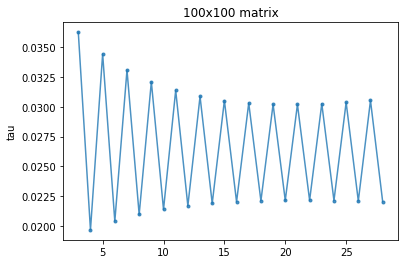

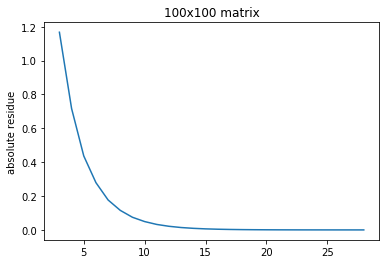

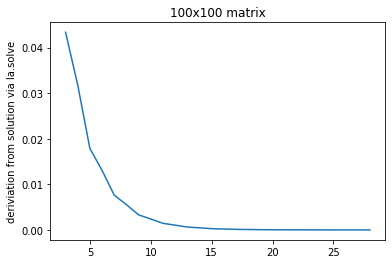

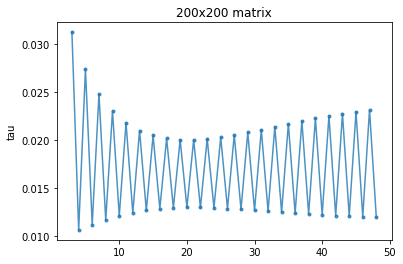

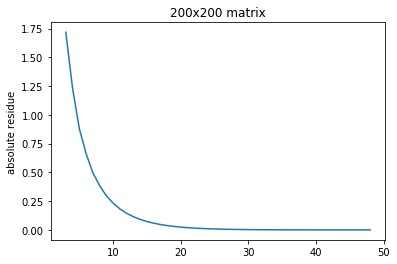

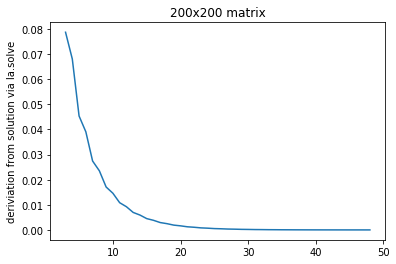

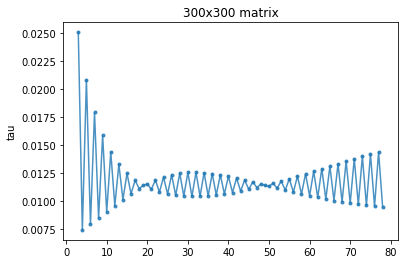

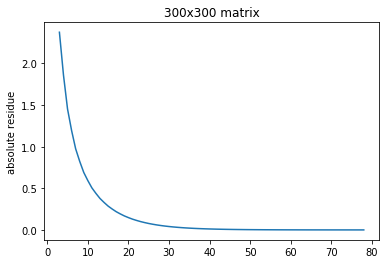

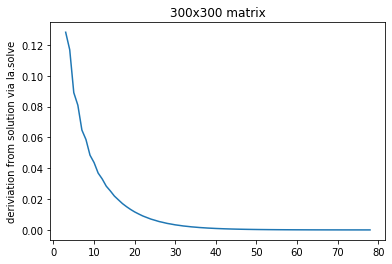

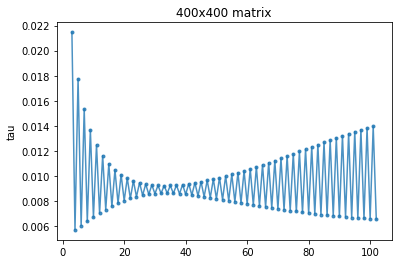

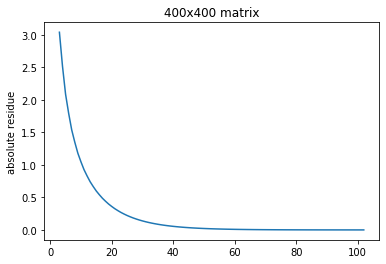

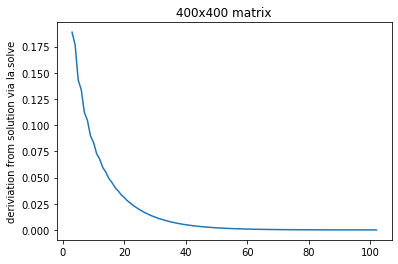

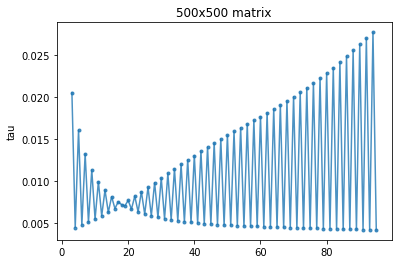

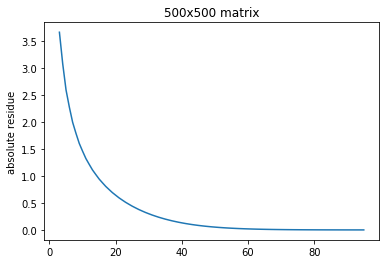

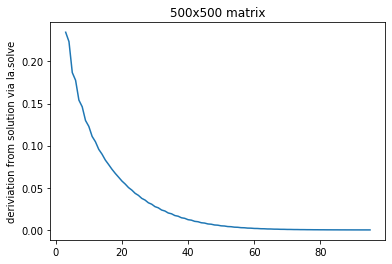

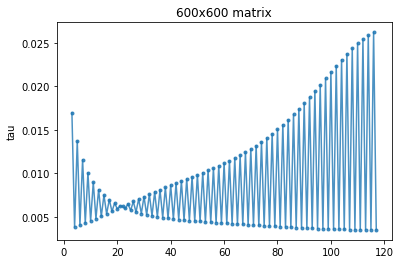

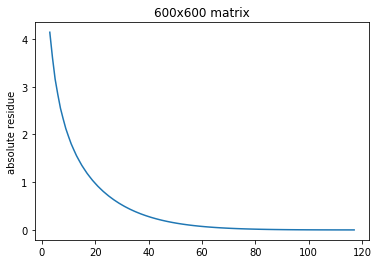

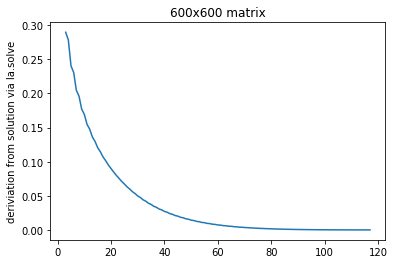

In [104]:
import matplotlib.pyplot as plt

for i in range(1,7):
    d = i*100
    Mat = rndm.uniform(size=(d, d)) + np.diagflat([15]*d)
    bb = rndm.uniform(size=d)

    t, r, der = _minimum_res(Mat, bb, np.ones_like(bb))
    step_num = np.arange(0,t.shape[0])
    plt.plot(step_num[3:], t[3:], ".-", alpha = 0.8)
    plt.ylabel("tau")
    plt.title("{}x{} matrix".format(d,d))
    plt.show()
    plt.plot(step_num[3:], r[3:])
    plt.ylabel("absolute residue")
    plt.title("{}x{} matrix".format(d,d))
    plt.show()
    plt.plot(step_num[3:], der[3:])
    plt.ylabel("deriviation from solution via la.solve")
    plt.title("{}x{} matrix".format(d,d))
    plt.show()

Отклонение от истинного решения и разница, вычисляемая по ходу цикла достаточно быстро уходят к нулю. 

Параметр тау осциллирует, притом его на разных тестах наблюдается всегда один и тот же паттерн, что амплитуда осцилляций тоже меняется, падая и поднимаясь на порядки. Притом величина осцилляций разная от матрицы к матрице (для больших матриц)